In [2]:
%matplotlib inline
from sensible_raw.loaders import loader
import pandas
from collections import defaultdict
import matplotlib.pylab as plt
import seaborn as sns
import subprocess
import os
import json
import datetime
from datetime import datetime as dt

# Feature extraction from bluetooth data

### Features to extract
    
    1. Sociability (probability of meeting above average number of people)
    2. Outreachingness (probability of a connection not being in study)
    3. Predictability
    (4. Probaility of being member of more than average cores)

In [7]:
# Load data
columns_bluetooth, data_bluetooth = loader.load_data("bluetooth", "february_2014")

dict_tmp = {}
for column, array in zip(columns_bluetooth, data_bluetooth):
    dict_tmp[column] = array
dataframe_bluetooth = pandas.DataFrame(dict_tmp)

In [8]:
# Make data_main
data_main = defaultdict(list)

counter = 0
for row in dataframe_bluetooth.iterrows():
    data_point = row[1].to_dict()
    data_main[data_point['user']].append({'timestamp': data_point['timestamp'], 
                                          'user': data_point['user'],
                                          'bt_mac': data_point['bt_mac']})
    
    counter += 1
    
    if counter % 100000 == 0:
        print counter,
        
data_main = dict(data_main)

100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000 1900000 2000000 2100000 2200000 2300000 2400000 2500000 2600000 2700000 2800000 2900000 3000000 3100000 3200000 3300000 3400000 3500000 3600000 3700000 3800000 3900000 4000000 4100000 4200000 4300000 4400000 4500000 4600000 4700000 4800000 4900000 5000000 5100000 5200000 5300000 5400000 5500000 5600000 5700000 5800000 5900000 6000000 6100000 6200000 6300000 6400000 6500000 6600000 6700000 6800000 6900000 7000000 7100000


In [9]:
print "Number of participants:", len(data_main)
print "Number of interactions:", len([item for sublist in data_main.values() for item in sublist])
print "Testing number correct:", len(list(dataframe_bluetooth['user']))

Number of participants: 696
Number of interactions: 7156686
Testing number correct: 7156686


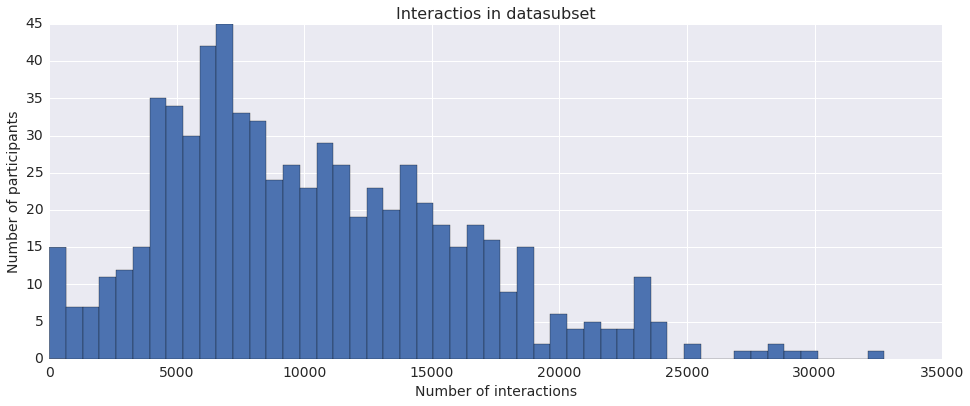

In [10]:
x = [len(d) for d in data_main.values()]
plt.figure(figsize=(16,6))
plt.hist(x,bins=50)
plt.title("Interactios in datasubset",fontsize=16)
plt.xlabel("Number of interactions",fontsize=14)
plt.ylabel("Number of participants",fontsize=14)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.show()

## 1. Sociability (probability of meeting above average number of people)

#### This feature answers the question:
- What is the time-uncorrelated probability that for a given day, the user will connect with people more than average?

#### To compute this feature, the strategy is as follows:
1. For each day compute the expected number of connections for a user
2. For each user, compute the fraction of times he/she is above the daily average

#### 1. 

In [72]:
# Define connections simply as timestamps
connections = sorted([item for sublist in data_main.values() for item in sublist], 
                     key=lambda x: x['timestamp'])

# Filter out connections between 8-17
hours_not_considered = range(8,12) + range(13,17)
connections = [c for c in connections if not dt.fromtimestamp(c['timestamp']/1000).hour in hours_not_considered]

# Start date
start_datetime = dt.fromtimestamp(connections[0]['timestamp']/1000)

In [73]:
# Data structure
daily_connections_count = defaultdict(int)
daily_users_set = defaultdict(set)

# Initial condition
counting_day_date = start_datetime.date()

# Compute connections pr. day
for connection in connections:
    connection_datetime = dt.fromtimestamp(connection['timestamp']/1000)
    
    if connection_datetime.date() == counting_day_date:
        daily_connections_count[counting_day_date] += 1
        daily_users_set[counting_day_date].add(connection['user'])
    else:
        print counting_day_date.day,
        counting_day_date += datetime.timedelta(days=1)

# Normalize daily_connections_count with number of users that interacted each day
daily_connections_count_average = dict((k, v*1.0/len(daily_users_set[k])) for k,v in daily_connections_count.items())

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27


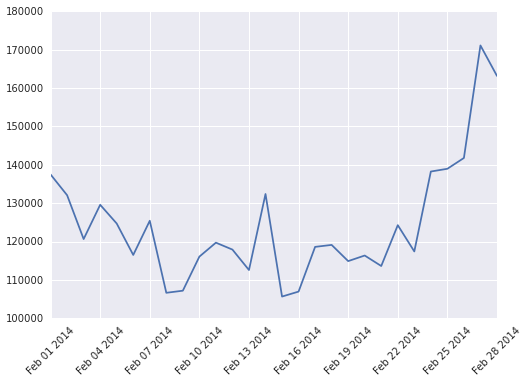

In [74]:
# Checking daily_connections_count
x, y = zip(*sorted(daily_connections_count.items(), key=lambda x: x[0]))
plt.plot(x, y); plt.xticks(rotation=45)
plt.show()

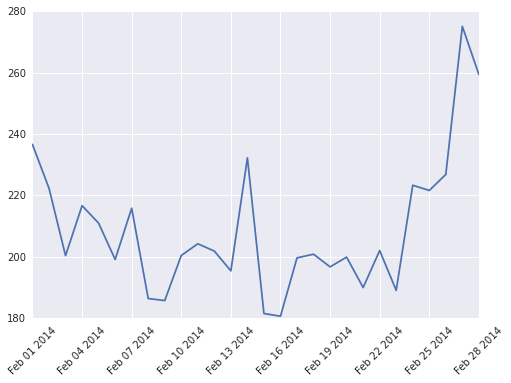

In [75]:
# Checking daily_connections_count_average
x, y = zip(*sorted(daily_connections_count_average.items(), key=lambda x: x[0]))
plt.plot(x, y); plt.xticks(rotation=45)
plt.show()

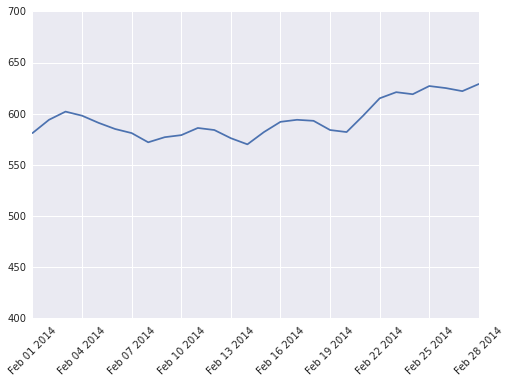

In [76]:
# Checking daily_users_set
x, y = zip(*sorted([(k, len(v)) for k, v in daily_users_set.items()], key=lambda x: x[0]))
plt.plot(x, y); plt.xticks(rotation=45)
plt.ylim([400,700])
plt.show()

#### 2. 

In [77]:
def compute_user_daily_connections_count(user):
    connection_timestamps = sorted([c['timestamp'] for c in data_main[user]
                                    if not dt.fromtimestamp(c['timestamp']/1000).hour in hours_not_considered])

    # Start date
    try:
        start_datetime = dt.fromtimestamp(connection_timestamps[0]/1000)
    except IndexError:
        print "user", user, "has no connections"
        return dict()
    
    # Data structure
    user_daily_connections_count = defaultdict(int)

    # Initial condition
    counting_day_date = start_datetime.date()

    # Compute connections pr. day
    for connection_timestamp in connection_timestamps:
        connection_datetime = dt.fromtimestamp(connection_timestamp/1000)

        if connection_datetime.date() == counting_day_date:
            user_daily_connections_count[counting_day_date] += 1
        else:
            counting_day_date += datetime.timedelta(days=1)
            #print counting_day_date.day,
            
    return user_daily_connections_count


def compute_user_sociability(user):
    """Compute the sociability of a user
    
    The sociability is defined as the fractions of days where the user
    meets above average number of people.
    
    Parameter
    ---------
    user : int
        The Id value of a user
    
    Out
    ---
    probability : float
        The probability that the user will meet above average number of
        people in a day
    """
    
    user_daily_connections_count = compute_user_daily_connections_count(user)
    
    days_above_average = 0
    days_count = len(daily_connections_count_average)
    
    for (day, count) in user_daily_connections_count.items():
        if count > daily_connections_count_average[day]:
            days_above_average += 1
            
    probability = days_above_average * 1.0 / days_count
    return probability

user 496 has no connections


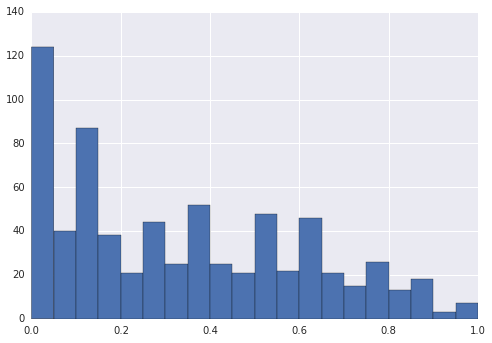

In [78]:
x = [compute_user_sociability(i) for i in data_main.keys()]
plt.hist(x,bins=20)
plt.show()

## 2. Outreachingness (probability of a connection not being in study)

#### This feature answers the question:
- What is the time-uncorrelated probability that any given connection will be outside of study?

In [85]:
def compute_user_outreachingness(user):
    connections = [c for c in data_main[user] if dt.fromtimestamp(c['timestamp']/1000).hour not in hours_not_considered]
    
    connections_unknown = [c for c in connections if c['bt_mac'] == -1]
    
    if len(connections) == 0:
        return 0.0
    
    probability = len(connections_unknown) * 1.0/len(connections)
    
    return probability

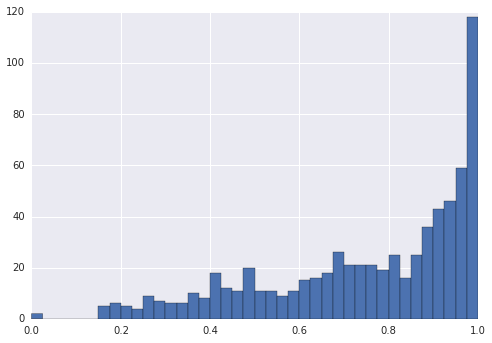

In [86]:
x = [compute_user_outreachingness(i) for i in data_main.keys()]
plt.hist(x,bins=40)
plt.show()

## 3. Predictability

#### To compute this feature, the strategy is as follows:
1. Compute the entropy.
    1. Create counter of every social state (connection)
    2. Normalise with all connections for user to get probability
    3. Compute entropy using $S_i^{unc}=\sum_j^{N_i} =p_j\log_2{p_j}$
2. Solve a limiting case Fano's inequality to find the predictability.

In [87]:
dataframe_bluetooth

,bt_mac,rssi,timestamp,user
0,-1,0,1393278485000,538
1,-1,0,1393278785000,538
2,-1,0,1393279085000,538
3,-1,0,1393279385000,538
4,-1,0,1393279685000,538
5,-1,0,1393279985000,538
6,-1,0,1393280285000,538
7,-1,0,1393280585000,538
8,-1,0,1393280885000,538
9,-1,0,1393281185000,538


In [94]:
sorted(set(dataframe_bluetooth['user']))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
